In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve


In [92]:
class Magnet:
    def __init__(self, position, momentum):
        self.position = np.array(position)
        self.momentum = np.array(momentum)
        
    def potential(self, theta, mu0=1, l=1):
        pendulum_direction = np.array([np.cos(theta), np.sin(theta)])
        pendulum_momentum = pendulum_direction
        pendulum_position = l * pendulum_direction
        
        r = pendulum_position - self.position
        r_norm = np.sqrt((r[0]**2 + r[1]**2))
        r_hat = r / r_norm
        
        B = (mu0 / 4 * np.pi) * (3 * r_hat * r_hat.dot(self.momentum) - self.momentum) / (r_norm**3)
        Um = -pendulum_momentum.dot(B)
        
        return Um
        # return mu0 / (4 * np.pi * r_norm**5) * ( np.dot(self.momentum, pendulum_momentum) - 3 * np.dot(self.momentum, r) * np.dot(pendulum_momentum, r) )
    
    def potential_derivative(self, theta, mu0=1, dtheta=1e-5, l=1):
        val0 = self.potential(theta, mu0=mu0, l=l)
        val1 = self.potential(theta + dtheta, mu0=mu0, l=l)
        
        return (val1 - val0) / (dtheta)

class System:
    def __init__(self, ic=[0, 0], damp=0.2, moment=1, mu0=1, length=1, dt=0.1, t_max=100):
        self.angle = ic[0]
        self.velocity = ic[1]
        self.damp = damp
        self.moment = moment
        self.mu0 = mu0
        self.length = length
        self.dt = dt
        self.t_max = t_max
        
        self.magnets = []
        self.angle_list = []
        self.velocity_list = []
        self.critical_points = []
        
    def add_magnet(self, magnet):
        self.magnets.append(magnet)
        
    def rhs(self, state):
        g = 1
        
        dL = -g / self.length * np.sin(state[0]) - self.damp * state[1]
        # dL = 0
        
        for magnet in self.magnets:
            dL += -magnet.potential_derivative(state[0], mu0=self.mu0, l=self.length)
        
        return np.array([state[1], dL])
        
    def rk4_step(self, state):
        k1 = self.rhs(state)
        k2 = self.rhs(state + self.dt / 2 * k1)
        k3 = self.rhs(state + self.dt / 2 * k2)
        k4 = self.rhs(state + self.dt * k3)
        
        return state + self.dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        
    def solve(self, save=True):
        num_steps = int(self.t_max / self.dt)
        
        state = np.array([self.angle, self.velocity])
        trajectory = [state]
        
        for _ in range(num_steps - 1):
            trajectory.append(self.rk4_step(trajectory[-1]))
        
        trajectory = np.array(trajectory)
        
        self.angle_list = trajectory[:, 0]
        self.velocity_list = trajectory[:, 1]
        self.critical_points = self.get_critical_points()
        
        if save:
            np.save("angle_list.npy", self.angle_list)
            np.save("velocity_list.npy", self.velocity_list)
            magnets = np.array([np.concatenate([magnet.position, magnet.momentum]) for magnet in self.magnets])
            np.save("magnets.npy", magnets)
            np.save("critical_points.npy", self.critical_points)
    
    def plot_solution(self, ax=None, color=None):
        if ax is None:
            fig, ax = plt.subplots()
            
        ax.set_title("Solution")
        ax.set_xlabel("Time")
        ax.set_ylabel("Angle")
        
        plt.plot(np.linspace(0, self.t_max, len(self.angle_list)), self.angle_list, color=color)
    
    def plot_potential(self, ax=None, color=None):
        if ax is None:
            fig, ax = plt.subplots()
            
        g = 1
        angles = np.linspace(0, 2 * np.pi, 500)
        
        def total_potential(angle):
            potential = g / self.length * (1 - np.cos(angle))
            for magnet in self.magnets:
                potential += magnet.potential(angle, mu0=self.mu0, l=self.length)
                
            return potential
        
        potentials = [total_potential(angle) for angle in angles]
        
        plt.plot(angles, potentials, color=color)
    
    def plot_potential_derivative(self, ax=None, color=None):
        if ax is None:
            fig, ax = plt.subplots()
        
        # ax.set_title("Potential")
        ax.set_xlabel("Angle")
        ax.set_ylabel("Potential")
        
        angles = np.linspace(0, 2 * np.pi, 500)
        dpotentials = [self.rhs([angle, 0])[1] for angle in angles]
        
        plt.plot(angles, dpotentials, color=color)
    
    def get_critical_points(self):
        critical_points = []
        initial_angles = np.linspace(0, 2 * np.pi, 500, endpoint=False)
        
        for angle in initial_angles:
            new_cp = fsolve(self.rhs, [angle, 0])[0] % (2 * np.pi)
            # print(new_cp)
            is_new = True
            for cp in critical_points:
                if np.abs(cp - new_cp) < 1e-3:# or not np.isclose(self.rhs([cp, 0])[1], 0):
                    is_new = False
                    break
            if is_new:
                critical_points.append(new_cp)
            
        # critical_points = np.array(critical_points)
        # np.save("critical_points.npy", critical_points)
        
        return np.array(critical_points)
    
    

C:\Users\gusta\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\gusta\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[0.11512938 5.77461879 3.06008417 1.67192184 0.78494502 1.67294518]


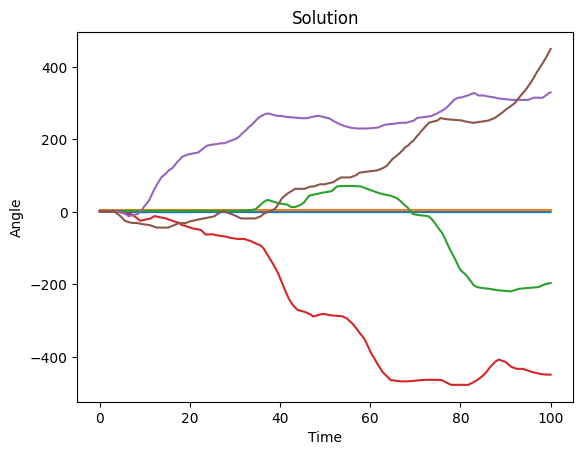

[  0.         -99.15470303]


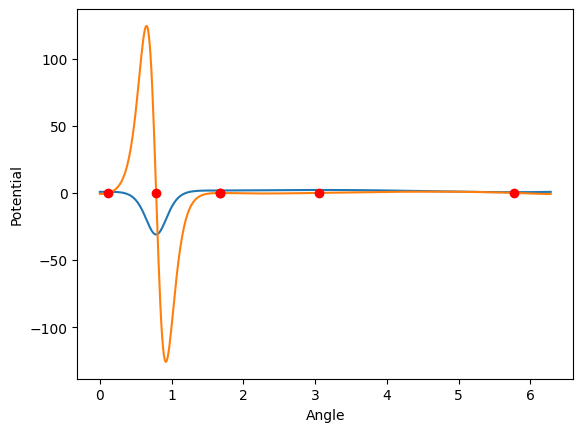

In [93]:
fig, ax = plt.subplots()

marcus = System()
marcus.add_magnet(Magnet([1, 1], [1, 1]))
crit_points = marcus.get_critical_points()
trajectory_values = []
print(crit_points)
for angle in crit_points:
# for angle in crit_points[::-1]:
    marcus.angle = angle
    marcus.velocity = 0
    marcus.solve()
    marcus.plot_solution(ax=ax)

# marcus.angle = 1.57512689
# marcus.velocity = 0
# marcus.solve()
# marcus.plot_solution(ax=ax, color="red")
plt.show()

fig, ax = plt.subplots()
marcus.plot_potential(ax=ax)
marcus.plot_potential_derivative(ax=ax)
plt.gca().plot(crit_points, [0] * len(crit_points), "ro")

print(marcus.rhs([1, 0]))


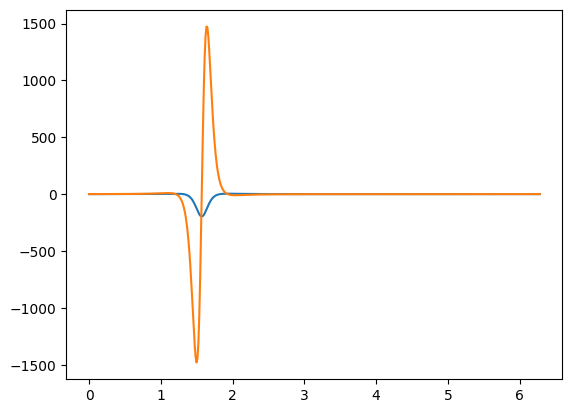

In [68]:
m = Magnet([0, 1.2], [0, 1])
thetas = np.linspace(0, 2 * np.pi, 500)
potentials = [m.potential(theta) for theta in thetas]
dpotentials = [m.potential_derivative(theta) for theta in thetas]
plt.plot(thetas, potentials)
plt.plot(thetas, dpotentials)
plt.show()